In [1]:
%matplotlib inline
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)

### Compiling Functions

#### An Example

In [2]:
α = 4.0

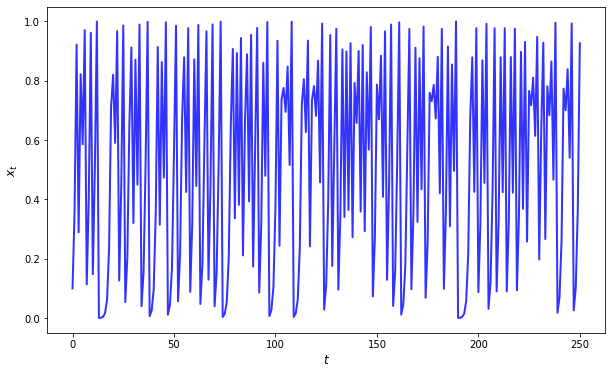

In [3]:
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

In [4]:
from numba import jit

qm_numba = jit(qm)

In [5]:
n = 10_000_000
qe.tic()
qm(0.1, int(n))
time1 = qe.toc()

TOC: Elapsed: 0:00:7.70


In [6]:
qe.tic()
qm_numba(0.1, int(n))
time2 = qe.toc()

TOC: Elapsed: 0:00:0.48


In [7]:
qe.tic()
qm_numba(0.1, int(n))
time3 = qe.toc()

TOC: Elapsed: 0:00:0.05


In [8]:
time1 / time3 # Calculate speed gain

130.46484471246865

### Decorators and “nopython” Mode

In [9]:
qm_numba = jit(qm)

#### Decorator Notation

In [10]:
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    
    return x

In [11]:
qm(0.1, 10)

array([0.1       , 0.36      , 0.9216    , 0.28901376, 0.82193923,
       0.58542054, 0.97081333, 0.11333925, 0.40197385, 0.9615635 ,
       0.14783656])

#### Type Inference and “nopython” Mode

In [12]:
from numba import njit

@njit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    
    return x

#### Compiling Classes

In [13]:
from numba import float64
from numba.experimental import jitclass

In [14]:
solow_data = [('n', float64),
              ('s', float64),
              ('δ', float64),
              ('α', float64),
              ('z', float64),
              ('k', float64)]

@jitclass(solow_data)
class Solow:
    r"""
    Implements the Solow growth model with the update rule
    k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)
    """
    
    def __init__(self, 
                 n = 0.05, # population growth rate
                 s = 0.25, # savings rate
                 δ = 0.1, # depreciation rate
                 α = 0.3, # share of labor
                 z = 2.0, # productivity
                 k = 1.0): # current capital stock
        
        self.n, self.s, self.δ, self.α, self.z = n, s, δ, α, z
        self.k = k
    
    
    def h(self):
        "Evaluate the h function"
    
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
    
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)
    
    
    def update(self):
        "Update the current state (i.e., the capital stock)."

        self.k = self.h()


    def steady_state(self):
        "Compute the steady state value of capital."
    
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
    
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))


    def generate_sequence(self, t):
        "Generate and return a time series of length t"

        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        
        return path

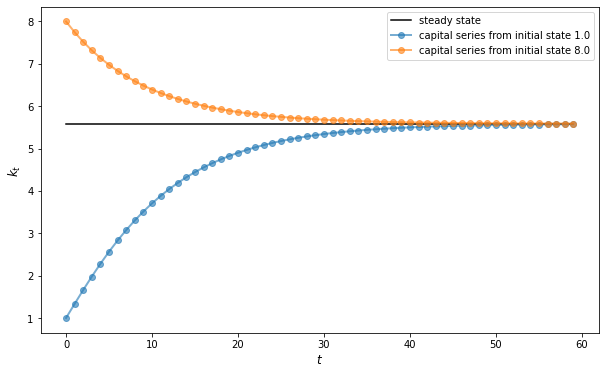

In [15]:
s1 = Solow()
s2 = Solow(k=8.0)
T = 60
fig, ax = plt.subplots()

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label = 'steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', 
            lw = 2, 
            alpha = 0.6,
            label = lb)

ax.set_ylabel('$k_{t}$', fontsize = 12)
ax.set_xlabel('$t$', fontsize = 12)
ax.legend()
plt.show()

### Summary and Comments

#### A Gotcha: Global Variables

In [16]:
a = 1

@jit
def add_a(x):
    
    return a + x

print(add_a(10))

11


In [17]:
a = 2
print(add_a(10))

11


### Exercises

In [18]:
from random import uniform

@njit
def calculate_pi(n=1_000_000):
    count = 0
    
    for i in range(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        
        if d < 0.5:
            count += 1
            area_estimate = count / n
    
    return area_estimate * 4 # dividing by radius**2

In [19]:
%time calculate_pi()

CPU times: total: 375 ms
Wall time: 425 ms


3.142812

In [20]:
%time calculate_pi()

CPU times: total: 31.2 ms
Wall time: 35.3 ms


3.14

In [21]:
p, q = 0.1, 0.2 # Prob of leaving low and high state respectively

In [22]:
def compute_series(n):
    x = np.empty(n, dtype=np.int_)
    x[0] = 1 # Start in state 1
    U = np.random.uniform(0, 1, size=n)
    
    for t in range(1, n):
        current_x = x[t-1]
        
        if current_x == 0:
            x[t] = U[t] < p
        else:
            x[t] = U[t] > q


    return x

In [23]:
n = 1_000_000
x = compute_series(n)
print(np.mean(x == 0)) # Fraction of time x is in state 0

0.667135


In [24]:
qe.tic()
compute_series(n)
qe.toc()

TOC: Elapsed: 0:00:0.93


0.9371457099914551

In [25]:
from numba import jit
compute_series_numba = jit(compute_series)

In [26]:
x = compute_series_numba(n)
print(np.mean(x == 0))

0.666938


In [27]:
qe.tic()
compute_series_numba(n)
qe.toc()

TOC: Elapsed: 0:00:0.02


0.02099919319152832

### End.